In [1]:
import glob
import spacy
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk import ngrams
from collections import Counter
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn import metrics

Error reading File
Error reading File
Error reading File


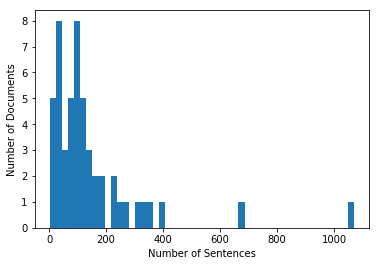

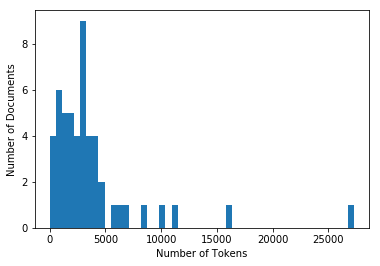

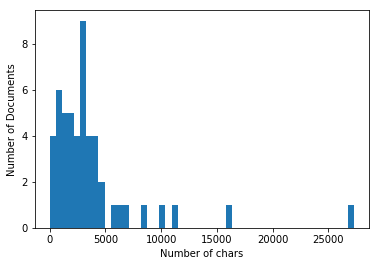

In [2]:
#Problem 1


numdocs = 50 #nuber of documents to be processed
path = '/home/tobias/Documents/RobotJudge/cases/' #path to the case files



cases = []
years = []
ids = []


files = glob.glob(path + '*.txt')
nlp = spacy.load('en')
i = 0


for file in files:
    if i > numdocs:
        break
    try:
        with open(file) as open_file:
            cases.append(open_file.read())
            years.append(re.findall(path + '(\d+)', file)[0])
            id = re.findall(path + '(\d+)_(\S)(\S)(\S)(\S)(\S)(\S)', file)[0]
            ids.append(''.join(id[1:7]))
            i += 1
    except:
            print("Error reading File")    

            
def runSpacy(txt):
    return nlp(txt)

def getNumSents(doc):
    return len(list(doc.sents))

def getNumToks(doc):
    return len(list(doc))

        
df  = pd.DataFrame({'caseid':ids,'text':cases, 'year':years})
df['doc'] = df['text'].apply(runSpacy)

df['numSen'] = df['doc'].apply(getNumSents)
df['numTok'] = df['doc'].apply(getNumToks)
df['numChars'] = df['doc'].str.len()

plt.hist(df['numSen'], numdocs)
plt.ylabel("Number of Documents")
plt.xlabel("Number of Sentences")
plt.show()

plt.hist(df['numTok'], numdocs)
plt.ylabel("Number of Documents")
plt.xlabel("Number of Tokens")
plt.show()

plt.hist(df['numChars'], numdocs)
plt.ylabel("Number of Documents")
plt.xlabel("Number of chars")
plt.show()


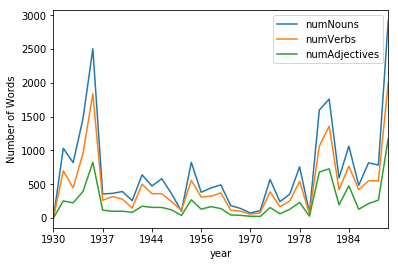

In [3]:
#Problem 2

def getNumNouns(doc):
    count = 0
    for tok in doc:
        if tok.pos_ == 'NOUN':
            count += 1
    return count

def getNumVerbs(doc):
    count = 0
    for tok in doc:
        if tok.pos_ == 'VERB':
            count += 1
    return count

def getNumAds(doc):
    count = 0
    for tok in doc:
        if tok.pos_ == 'ADJ':
            count += 1
    return count

df['numNouns'] = df['doc'].apply(getNumNouns)
df['numVerbs'] = df['doc'].apply(getNumVerbs)
df['numAdjectives'] = df['doc'].apply(getNumAds)

ax = df.groupby('year')['numNouns'].mean().plot()
ax = df.groupby('year')['numVerbs'].mean().plot()
ax = df.groupby('year')['numAdjectives'].mean().plot()
ax.set_ylabel("Number of Words")
plt.legend()
plt.show()




In [1]:
#Problem 3
def normalize(doc): #code snippet from Solutions_01
    tokens = []
    for sent in doc.sents:
        sent = str(sent)
        sent = sent.replace('\r', ' ').replace('\n', ' ')
        lower = sent.lower() # all lower case
        nopunc = lower.translate(translator) # remove punctuation
        words = nopunc.split() # split into tokens
        no_numbers = [w if not w.isdigit() else '#' for w in words] # normalize numbers
        stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
        tokens += stemmed # add to list of tokens for this document
        #Do not remove names because some laws are named after people or places
        #Do not remove stopwords because they can be important in legal documents and I got much better results with stopwords
    return tokens


df['cleanToken'] = df['doc'].apply(normalize)

def findTriGrams(doc):
    trigram = []
    for i in range(0, len(doc) - 2):
        if doc[i+2].pos_ == 'NOUN': # and str(doc[i]) != '#' and str(doc[i+1]) != '#' and str(doc[i+2]) != '#':
            trigram.append(str(doc[i]) + " " + str(doc[i+1]) + " " + str(doc[i+2]))
                        
    return trigram
        
def makeDoc(tokens):
    return nlp(' '.join(tokens))

    
df['cleanTokenDoc'] = df['cleanToken'].apply(makeDoc)
df['trigrams'] = df['cleanTokenDoc'].apply(findTriGrams)
df['trigrams'][0][:5]


NameError: name 'df' is not defined

In [77]:
#Problem 4
termFrequencies = Counter()

for trigram in df['trigrams']:
    termFrequencies.update(trigram)

x = statistics.stdev(termFrequencies.values())



trigramsList = set(x[0] for x in termFrequencies.most_common()[:1000])

freqs = []
for tris in df['trigrams']:
    count = Counter(tris)
    for key in count:
        count[key] /= x
    freqs.append({key: count[key] for key in count if key in trigramsList})

    
features = pd.DataFrame(freqs)
features['caseid'] = df['caseid']

featuresSparse = features.to_sparse()

featuresSparse.head()

,# # #,# # cir,# # f2d,# # l,# # led2d,# # ne2d,# # sct,# # stat,# # unit,# # usca,...,within the mean,within the purview,within the rule,within the scope,within the term,wright v roseberri,writ of error,y m c,york stock exchang,caseid
0,NaN,NaN,NaN,NaN,0.248647,0.248647,0.248647,NaN,NaN,0.745940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X21KR0
1,NaN,NaN,0.248647,NaN,0.745940,NaN,2.237819,NaN,NaN,NaN,...,0.745940,0.248647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X2NJD6
2,0.248647,NaN,NaN,NaN,NaN,NaN,1.491880,NaN,NaN,0.994586,...,0.248647,0.497293,NaN,NaN,0.497293,NaN,NaN,NaN,NaN,X40B69
3,NaN,NaN,0.248647,NaN,0.248647,NaN,0.497293,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X9VH38
4,2.237819,NaN,NaN,NaN,3.729699,NaN,4.475639,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XABN4A


In [6]:
#Problem 5

dfRev = pd.read_csv('/home/tobias/Documents/RobotJudge/case_reversed.csv')


join = features.merge(dfRev, on='caseid')

join.dropna(subset=['case_reversed'])

join.fillna(0, inplace=True)

logReg= LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(join.drop(columns=['case_reversed','caseid']), join['case_reversed'], test_size=0.25)

logReg.fit(X_train, y_train)
pred = logReg.predict(X_test)



print('Accuracy: ' + str(logReg.score(X_test, y_test)))
print('F1: '+ str(f1_score(y_test, pred)))

Accuracy: 0.7692307692307693
F1: 0.823529411764706


/home/tobias/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/home/tobias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/tobias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/tobias/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tobias/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy: 0.6923076923076923
F1: 0.8


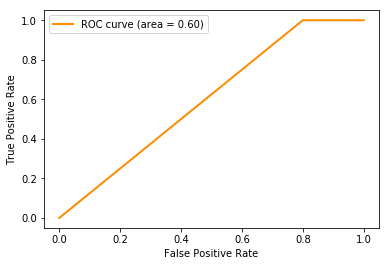

In [7]:
#Problem 6
params = {'C':[.001,.01,.1,1,10,11]}

grid = GridSearchCV(logReg,params,n_jobs=-1)
grid.fit(X_train[:100], y_train[:100])

print(grid.best_estimator_)

logReg = grid.best_estimator_
logReg.fit(X_train, y_train)
pred = logReg.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=2)
print('Accuracy: ' + str(logReg.score(X_test, y_test)))
print('F1: '+ str(f1_score(y_test, pred)))


n_classes = len(y_train)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test, pred)
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        
        
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

In [8]:
#Problem 7

sentences = []

for doc in df['doc']:
    for sent in doc.sents:
        sentences.append(sent)
        
sents = pd.DataFrame({'sents':sentences})

analyser = SentimentIntensityAnalyzer()

def sentimentAnalyzerScores(sentence):
    score = analyser.polarity_scores(sentence)
    return list(score.values())[3]
    
def toString(sent):
    return str(sent)

sents['sentsString'] = sents['sents'].apply(toString)
sents['score'] = sents['sentsString'].apply(sentimentAnalyzerScores)
pd.set_option('display.max_colwidth', -1)

print('Lowest compund score:')
sents[['sentsString','score']].sort_values(by=['score']).head(10)


Lowest compund score:


,sentsString,score
3809,Fretwell argued that his counsel was ineffective because counsel failed to object to the aggravating circumstances jury instructions; because counsel failed to prepare and present evidence at the suppression hearing on Fretwell's confession; because counsel argued for an erroneously-worded jury instruction on the lesser included offense of first degree murder; and because counsel failed to investigate or prepare for the sentencing phase.\n,-0.9747
3541,"To decide whether the government has violated Ursery's constitutional right this court must make three key determinations: (1) whether the civil forfeiture in the instant case constitutes "" punishment "" for double jeopardy purposes; (2) whether the civil forfeiture and criminal conviction are punishment for the same offense; and (3) whether the civil forfeiture and criminal prosecution are separate proceedings .\n",-0.9723
2301,"The words 'in contemplation of death' mean that the thought of death is the impelling cause of the transfer, and while the belief in the imminence of death may afford convincing evidence, the statute is not to be limited, and its purpose thwarted, by a rule of construction which in place of contemplation of death makes the final criterion to be an apprehension that death is 'near at hand.'\n",-0.9654
3618,"The government argues that the civil forfeiture and criminal conviction here do not constitute punishment for the same offense because the criminal prosecution requires proof that a person , the defendant, committed the crime, while the forfeiture requires proof that the property subject to forfeiture has been involved in the commission of a criminal violation.\n",-0.9637
3513,Discussion Ursery argues that his criminal prosecution and punishment after settlement of a civil forfeiture proceeding based on the same conduct violated the Double Jeopardy Clause of the Fifth Amendment .\n,-0.9578
3652,"The government points to the Eleventh Circuit's explanation that, ""[a]s in Millan , there is no problem here that the government acted abusively by seeking a second punishment because of dissatisfaction with the punishment levied in the first action.""\n",-0.9538
3536,"T]he Double Jeopardy Clause protects against three distinct abuses: a second prosecution for the same offense after acquittal; a second prosecution for the same offense after conviction; and multiple punishments for the same offense.""\n",-0.9485
599,"Moreover, the government has cited and our research has uncovered no case in which 15 U.S.C. 77q(a)(1) has been used to prosecute a defendant for fraud in the sale of securities perpetrated upon an agent-broker, where no investor has been deceived or defrauded as a result of the fraud.\n",-0.9371
3904,"Jurek involved a capital sentencing scheme in which the constitutional narrowing of the class of defendants eligible for the death penalty occurred at the guilt phase, in the form of a narrowly defined capital murder statute.\n",-0.9360
6320,But this inherent obstructive effect of perjury is not sufficient to constitute the additional obstruction required to make a false witness also guilty of contempt.\n,-0.9294


In [9]:
print('Highest compund score:')
sents[['sentsString','score']].sort_values(by=['score']).tail(10)

Highest compund score:


,sentsString,score
4541,"If the parties are in agreement as to the amount, copies of their computation are filed for entry of the decision; but, if not in agreement, the parties may file their respective computations, and an opportunity to be heard is afforded.\n",0.9595
2102,"He could not effect any change in the beneficial interest in the trusts without the consent, in the case of four of the trusts, of the person entitled to that interest, and in the case of one trust without the consent of a majority of those so entitled.\n",0.9599
2076,"But it seems to us tolerably plain, that when the grantor parts with all his interest in the property to other persons in trust, with no thought of avoiding taxes, the fact that the income vested in the beneficiaries was to be accumulated for them instead of being handed to them to spend (italics ours), does not make the trust one intended to take effect in possession or enjoyment at or after the grantor's death.""\n",0.9612
2110,"""But the question much pressed upon us remains whether, the donor having parted both with the possession and his entire beneficial interest in the property when the trust was created, the mere passing of possession or enjoyment of the trust fund from the life tenants to the remaindermen after the testator's death, as directed, and after the enactment of the statute, is included within its taxing provisions.\n",0.9628
2214,"We said in that case: ""Had the decedent in the case at bar retained the legal title to all of the trust property, and had he provided that, upon his death, and not before, such title should pass to his daughter or to others or to a trustee for her or their benefit, the situation would be comparable to that in the Klein Case; but here the decedent parted with the legal title to the trust property and to all beneficial interest therein during the life of the trust, and did so irrevocably.\n",0.9661
5783,"But, be that as it may, we are clearly of opinion that the courts are without jurisdiction to grant relief in favor of one claiming only an equitable title, as against a party in possession under a lease from the United States, so long as the title remains in the United States.""\n",0.9663
2162,"*"" Mr. justice Roberts, in an opinion concurred in by Mr. Justice Holmes, Mr. Justice Brandeis, and Mr. Justice Stone, dissented upon the ground that the Massachusetts statute sought to tax the privilege to succeed and enjoy, rather than the privilege to transfer, and that such privilege of succession was not fully exercised until after the death of the surviving settlor, when the taxing statute was in force.\n",0.9766
5260,"It would require a clear case to warrant a court of equity in declaring that the trustees of an express trust, in the very course of their administration of the trust, had acquired a dominant interest in the trust property and in effect a discharge of the trust, through mere inattention or even negligence--not raising an estoppel or amounting to laches--on the part of the parties beneficially interested, or of their executive officers.\n",0.9796
1990,"Out of the income and revenue accruing from said trust estate I shall have power to pay all taxes, expenses necessarily or properly incident to its care, preservation and management; and all other reasonable or necessary charges incident to the administration of the trust created hereby, and out of the remaining income and revenue, I am to pay the beneficiary of this trust an allowance of $300.00 a month, with power in my discretion from time to time to increase or decrease the said allowance whenever I may deem it to be to the best interest of the said beneficiary, to have such allowance increased or decreased.\n",0.9818
3712,"(12) That it was solely by reason of the Ballards' teachings and their embodiment in the ""I Am"" movement and by reason of the Ballards' divine power and influence that the United States was saved from destruction; that, by divine inspiration, there had been a

In [10]:
#Problem 8

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sents['sentsString'])

sentsCount = 2000 #Calculating cosine similarity of more sentences takes a lot of time and there are already interesting results with 2000 sentences 

sim = cosine_similarity(X[:sentsCount])

maxv = 0.0
minv = 1.0
maxi = [0, 0, 0, 0, 0]
maxj = [0, 0, 0, 0, 0]
mini = [0, 0, 0, 0, 0]
minj = [0, 0, 0, 0, 0]


for k in range(5):
    for i in range(sentsCount):
        for j in range(sentsCount):
            if sim[i][j] > maxv and i != j and sim[i][j] < 1: #Equal sentences are boring
                maxv = sim[i][j]
                sim[i][j] = 0.5
                sim[j][i] = 0.5
                maxi[k] = i
                maxj[k] = j
                
            if sim[i][j] < minv and sim[i][j] > 0: #Sentences with similarity 0 are boring
                minv = sim[i][j]
                sim[i][j] = 0.5
                sim[j][i] = 0.5
                mini[k] = i
                minj[k] = j
    maxv = 0
    minv = 1.0
    
print('Very similar sentences: ')
for i in range(5):
    print("Sentences ",maxi[i], " and ", maxj[i], ":")
    print(sents['sentsString'][maxi[i]]) 
    print('')
    print(sents['sentsString'][maxj[i]])
    print('')
    
print('Very unsimilar sentences: ')
print('')
for i in range(5):
    print("Sentences ",mini[i], " and ", minj[i], ":")
    print(sents['sentsString'][mini[i]]) 
    print('')
    print(sents['sentsString'][minj[i]])
    print('')

Very similar sentences: 
Sentences  1481  and  1690 :
United States v. Playboy Entertainment Group, Inc. , 529 U.S. 803 , 120 S.Ct.

See United States v. Playboy Entertainment Group, Inc. , 529 U.S. 803 , 120 S.Ct.

Sentences  1760  and  1767 :
See ABA Model Code of Jud.


ABA Model Code of Jud.


Sentences  1777  and  1881 :
See Shrink Mo. , 120 S.Ct.

See also Shrink Mo. , 120 S.Ct.

Sentences  1536  and  1873 :
See Shrink Mo. , 120 S.Ct.

Shrink Mo. , 120 S.Ct.

Sentences  1777  and  1873 :
See Shrink Mo. , 120 S.Ct.

Shrink Mo. , 120 S.Ct.

Very unsimilar sentences: 

Sentences  961  and  1209 :
See, e.g. , Affiliated Ute Citizens , supra (employees of a bank acting as stock transfer agent who "facilitated" sales of shares); Capital Gains Research Bureau , supra (financial adviser, under the Investment Advisers Act of 1940); Zweig v. Hearst Corp. , 594 F.2d 1261

Canon 5 restricts candidates for judicial office from attending and speaking at partisan political gatherings; identifyi

In [11]:
#Problem 9

numClusters = 20
km = KMeans(n_clusters=numClusters,n_jobs=-1)
km.fit(X[:1000])

docClusters = km.labels_.tolist()
dfs = sents[:1000]


dfs['cluster'] = docClusters
dfs[dfs['cluster']==1]['sentsString']
dfs[dfs['cluster']==2]['sentsString']

for i in range(20):
    print('CLUSTER: ', i)
    print(dfs[dfs['cluster']==i]['sentsString'].head(5))

CLUSTER:  0
0      PER CURIAM.\n                                         
38    [ 29 U.S.C.A. 157 .]\n                                 
51    The court enjoined the parties from such arbitration.\n
60    Vertrieb Kosmetischer Artikel                          
80    We disagree.\n                                         
Name: sentsString, dtype: object
CLUSTER:  1
893    The essence of the SEC's position, and the legal basis for its censure, is that Dirks and his clients had a duty under subsection (c) 12 to disclose the material information they possessed or refrain from trading Equity Funding securities as long as the information had not been disseminated to the public.\n
894    The concept of a duty to "disclose-or-refrain" under Rule 10b-5 originated in the SEC's benchmark decision in Cady, Roberts & Co. , 40 S.E.C.\n907 (1961).\n                                                                                                                                                        
8

/home/tobias/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
